In [28]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Part 1: Camera Calibration & Undistortion

## Camera Calibration Example Images

Text(0.5,1,'Example Image 3')

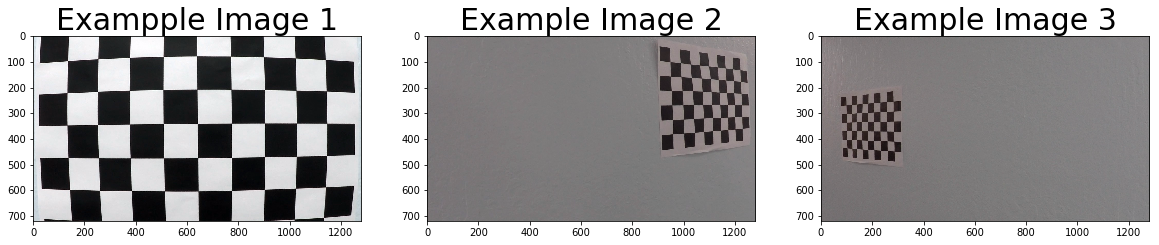

In [29]:
#Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

#load images
img1= cv2.imread(images[0])
img2= cv2.imread(images[5])
img3= cv2.imread(images[10])

#plot images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(img1)
ax1.set_title('Exampple Image 1', fontsize=30)
ax2.imshow(img2)
ax2.set_title('Example Image 2', fontsize=30)
ax3.imshow(img3)
ax3.set_title('Example Image 3', fontsize=30)


## 1.Find Chessboard Corners in Images

Text(0.5,1,'Chessboard Corners Image 10')

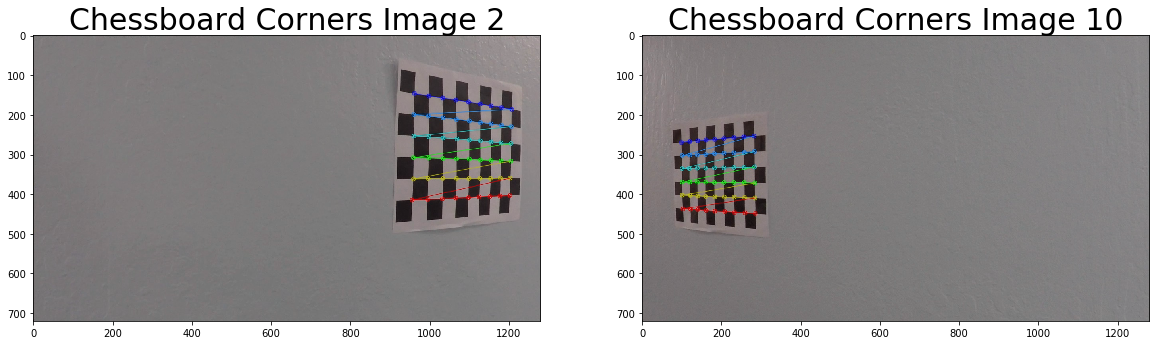

In [30]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        cv2.imwrite("output_images/" + write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

#plot images
img_corner_2 = cv2.imread("output_images/corners_found2.jpg")
img_corner_10 = cv2.imread("output_images/corners_found10.jpg")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_corner_2 )
ax1.set_title('Chessboard Corners Image 2', fontsize=30)
ax2.imshow(img_corner_10)
ax2.set_title('Chessboard Corners Image 10', fontsize=30)

## 2. Find Camera Matrix and Distortion Coefficients

Text(0.5,1,'Undistorted Image')

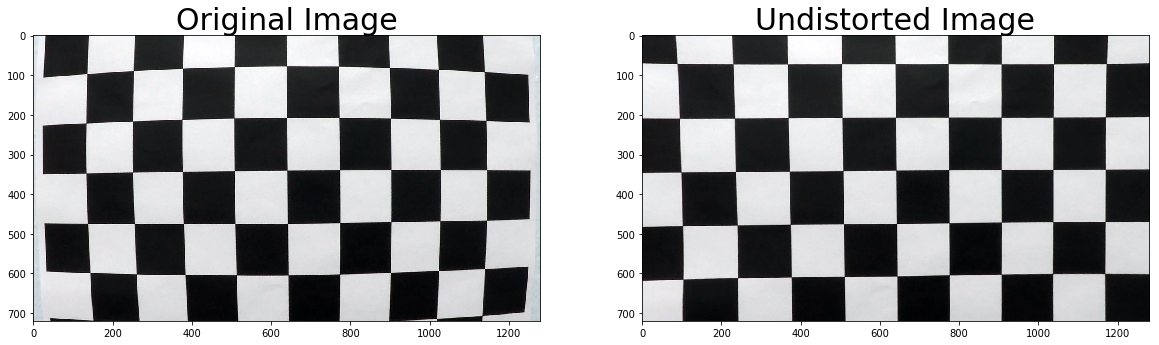

In [31]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## 3.Undistort raw test images

Text(0.5,1,'Undistorted Image')

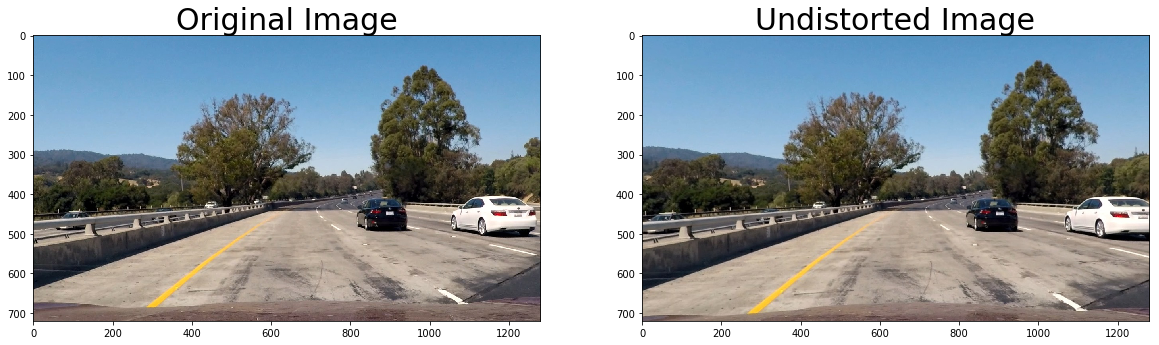

In [32]:
#load and undistort test images
test_images = sorted(glob.glob('test_images/test*.jpg'))
for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('output_images/test_undist' + str(idx+1) + '.jpg',dst)

test_img1 = plt.imread('test_images/test1.jpg')
test_undist1 = plt.imread('output_images/test_undist1.jpg')                        

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_undist1)
ax2.set_title('Undistorted Image', fontsize=30)

# Part 2. Create thresholded binary images

## 1. Threshold Helper Functions: Absolute Sobel, Gradient magnitude, direction, 

In [33]:
#Thresholding pipeline for Sobel-x and S-Colorspace

def  binary_threshold_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined = np.zeros_like(sxbinary)
    combined[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) | (scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    return combined

## 2. Apply thesholding and display example image

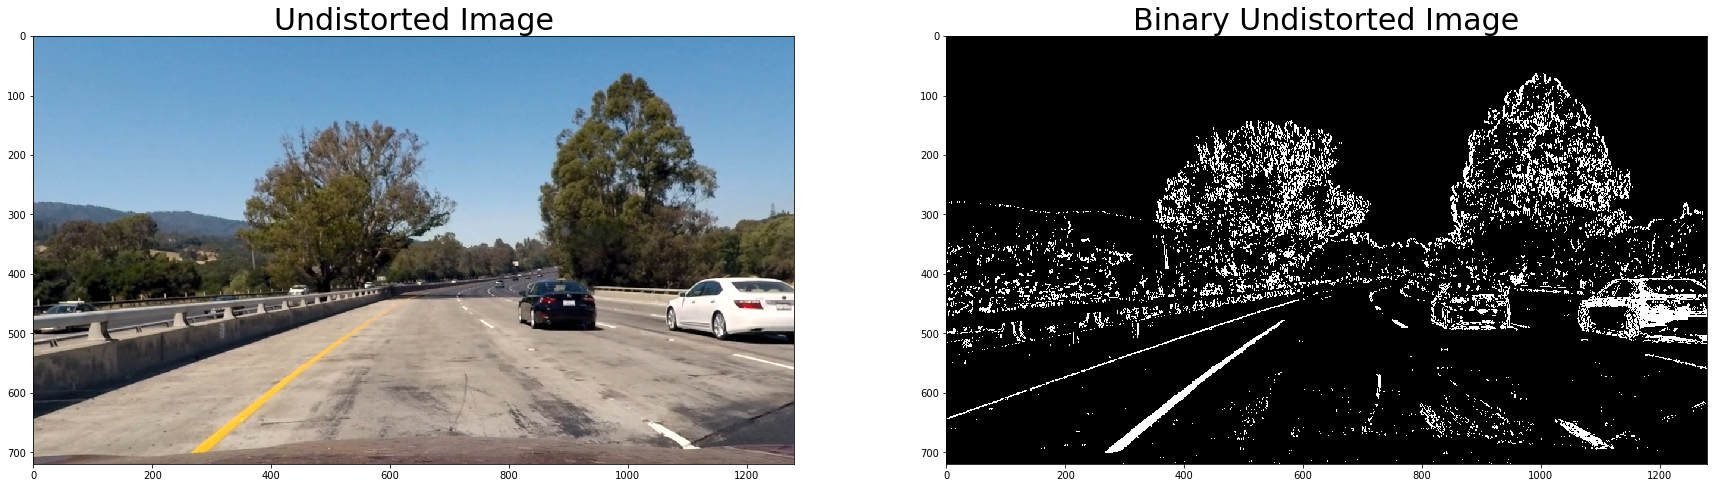

In [34]:
test_img_binary1 =  binary_threshold_pipeline(test_undist1)

# Visualize thresholding for binary image                      
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,20))
ax1.imshow(test_undist1)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(test_img_binary1,cmap=plt.cm.gray)
ax2.set_title('Binary Undistorted Image', fontsize=30)


undist_images = sorted(glob.glob('output_images/test_undist*.jpg'))
#Apply thresholding pipeline to all example images
for idx, fname in enumerate(undist_images):
    img = cv2.imread(fname)
    img_bin = binary_threshold_pipeline(img)
    cv2.imwrite('output_images/test_binary' + str(idx+1) + '.jpg',img_bin*255)



# Part 3: Transform images to "birds-eye-view"

Text(0.5,1,'BEV-Image')

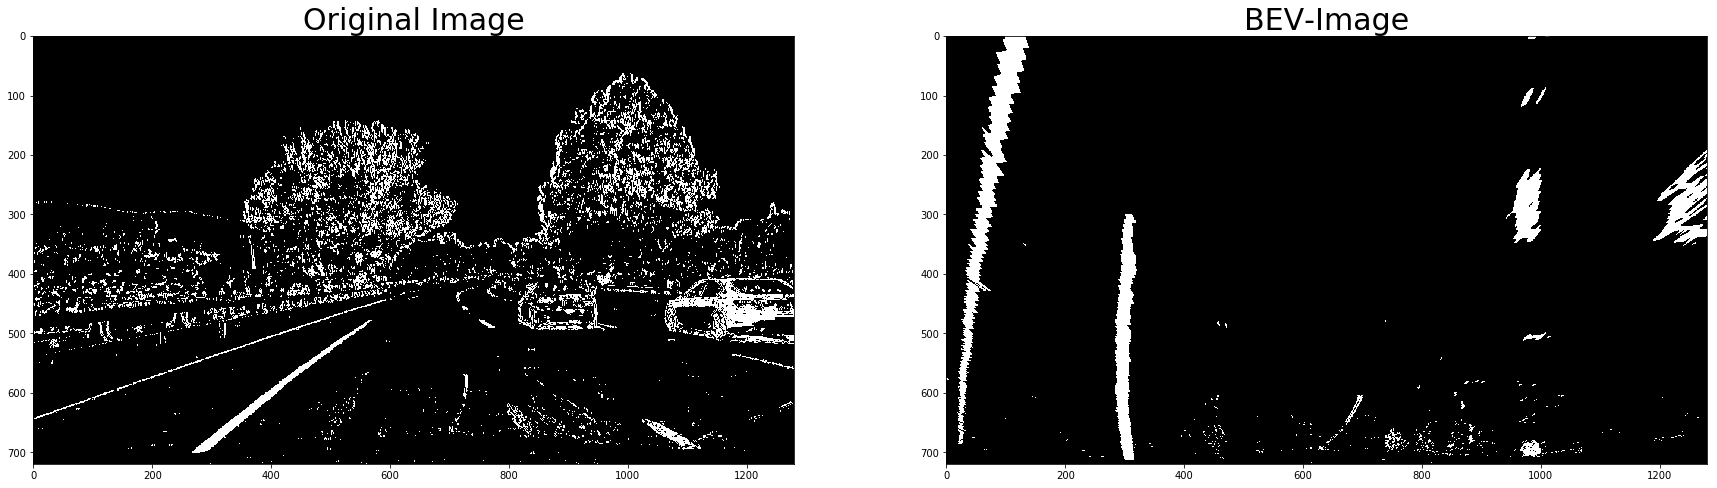

In [35]:
#Hard code 4 Corners which represents the field of view
img_size = (int(test_img_binary1.shape[1]), int(test_img_binary1.shape[0]))

src_pts = np.float32([[600,455],[270,720],[1127,720],[720,460]])
dst_pts = np.float32([[320,0],[320,720],[960,720],[960,0]])

#Compute the perspective transform, M, given source and destination points
M = cv2.getPerspectiveTransform(src_pts, dst_pts)

#transform the image
warped = cv2.warpPerspective(test_img_binary1, M, img_size, flags=cv2.INTER_LINEAR)

# Visualize Birdseye-View Image                   
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,20))
ax1.imshow(test_img_binary1,cmap=plt.cm.gray)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped,cmap=plt.cm.gray)
ax2.set_title('BEV-Image', fontsize=30)



In [39]:
undist_binary_images = sorted(glob.glob('output_images/test_binary*.jpg'))
#Apply birds-eye-view transformation to all undistorted binary images
for idx, fname in enumerate(undist_binary_images):
    img = cv2.imread(fname)
    img_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    cv2.imwrite('output_images/test_bev' + str(idx+1) + '.jpg',img_warped)

# Part 4: Identify lane lines with polynomial fit and slinding window algorithm